# K-Prototype Clustering for Clinical Deterioration Analysis

This notebook implements the following workflow:
1. Data loading from MySQL database
2. Feature preparation and preprocessing
3. K-prototype clustering of patient time series
4. Evaluation of clusters in relation to clinical deterioration outcomes
5. Survival analysis and visualization of cluster characteristics

In [ ]:
# Database connection imports and configuration
import json
import sys
import pandas as pd
import os
import sys

# Define project root path for module imports
ROOT_PATH = "/Users/xaviborrat/Documents/GitHub/TFM_Clinical_Deterioration"
sys.path.append(ROOT_PATH)

# Import custom database connection class
import classes
from classes.xavi_con_class import db_connect as xcc

In [3]:
# Load database configuration from JSON file
config_path = os.path.join(ROOT_PATH, 'classes/config_tfm.json')
with open(config_path, 'r') as configDnx:
    configDnx = json.load(configDnx)

# Initialize database connection object
datanex = xcc(
    ssh = configDnx["ssh"],
    ssh_user = configDnx["ssh_user"],
    ssh_host = configDnx["ssh_host"],
    ssh_pkey = configDnx["ssh_pkey"],
    db_host = configDnx["db_host"],
    db_port = configDnx["db_port"],
    db_user = configDnx["db_user"],
    db_pass = configDnx["db_pass"],
    flavour = configDnx["flavour"],
    db = configDnx["db"]
)

In [4]:
# Explore available vital sign variables
# Query to count occurrences of each vital sign type
datanex.query('borrat_project',"""SELECT rc_sap_ref, COUNT(*) 
                                   FROM vitals 
                                   GROUP BY rc_sap_ref 
                                   ORDER BY COUNT(*) DESC""")

Database [borrat_project] session created...
<> Query Sucessful <>


,rc_sap_ref,COUNT(*)
0,FC,869671
1,P_ART_S,601554
2,FR,596949
3,PULSIOX,562378
4,P_ART_D,561438
5,TEMP,516588
6,DOLOR_ENO,472124
7,ESTADO_CONCIENC,430416
8,NEWS_2,388002
9,O2_DIS,310875


In [5]:
# Explore available laboratory test variables 
# Query to find most frequent lab tests (>50,000 occurrences)
labs = datanex.query('borrat_project',"""SELECT lab_sap_ref, COUNT(*) AS contador 
                     FROM labs 
                     GROUP BY lab_sap_ref 
                     HAVING contador > 50000 
                     ORDER BY COUNT(*) DESC""")

# Get lab test dictionary for reference names
dict_lab = datanex.query('datascope4',"""SELECT * FROM dic_lab""")

# Merge lab frequencies with their descriptions
merged = labs.merge(dict_lab, left_on='lab_sap_ref', right_on='lab_sap_ref', how='left')

merged

Database [borrat_project] session created...
<> Query Sucessful <>
Database [datascope4] session created...
<> Query Sucessful <>


,lab_sap_ref,contador,lab_descr,units,lab_ref
0,LAB1300,68800,Leucocitos recuento,10^9/L,25
1,LAB1322,68799,CCMH concentraciion corpuscal m,g/L,48
2,LAB1320,68799,VCM,fl,46
3,LAB1321,68798,HCM hb corpusclar media,pg,47
4,LAB1314,68797,Hemoglobina concentracion,g/L,39
5,LAB1323,68796,RDW Reed Distribut Width,%,49
6,LAB1301,68794,Plaquetas recuento,10^9/L,26
7,LAB1308,68783,Linfocitos % analizado,%,33
8,LAB1306,68712,Neutrofilos % analizado,%,31
9,LAB1302,68583,VPM Volumen Plaquetario Medio,fl,27


In [6]:
# Prepare four tables to concatenate: ward stays, labs, and vitals (numeric and text)
# All tables will have the same structure: stay_id, concept, value, timestamp

# Define minimum stay duration in hours to include in analysis
stay_min = 48

# 1. Ward stays table - Extract age and medical unit from ward stays
ws = datanex.query('borrat_project',f"""
                    SELECT stay_id,
                        'age' AS concept,
                        age_on_admission AS value,
                        start_date AS time_stamp
                    FROM ward_stays_ds
                    WHERE care_level_type_ref = 'WARD'
                    AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}
                    UNION ALL
                    SELECT stay_id,
                        'medical_unit'  AS concept,
                        ou_med_ref      AS value,
                        start_date      AS time_stamp
                    FROM ward_stays_ds
                    WHERE care_level_type_ref = 'WARD'
                    AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}
                    ;""")

# 2. Numeric vital signs table - Selected vital signs
vitals_numerics = datanex.query('borrat_project',f"""SELECT stay_id, rc_sap_ref AS concept, result_num AS value, result_date AS time_stamp 
                                FROM vitals_ds
                                WHERE rc_sap_ref IN (
                                'FC',              -- Heart rate
                                'P_ART_S',         -- Systolic blood pressure
                                'TEMP',            -- Temperature
                                'PULSIOX',         -- Oxygen saturation
                                -- 'GLIC_CAPIL',   -- Capillary glycemia (commented out)
                                'FR'               -- Respiratory rate
                                )
                                AND stay_id IN(
                                SELECT stay_id
                                FROM borrat_project.ward_stays_ds
                                WHERE care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

# 3. Text vital signs table - Selected categorical vitals
vitals_text = datanex.query('borrat_project',f"""SELECT stay_id, rc_sap_ref AS concept, result_txt AS value, result_date AS time_stamp 
                            FROM vitals_ds
                                WHERE rc_sap_ref IN (
                                'EPOC',            -- COPD status
                                'ESTADO_CONCIENC', -- Level of consciousness
                                'O2_DIS',          -- Oxygen delivery method
                                'CAR_RITM'         -- Cardiac rhythm
                                ) 
                                AND stay_id IN(
                                SELECT stay_id
                                FROM borrat_project.ward_stays_ds
                                WHERE care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

# 4. Labs table - Selected laboratory tests
labs = datanex.query('borrat_project',f"""SELECT stay_id, lab_sap_ref AS concept, result_num AS value, extract_date AS time_stamp
                                FROM labs_ds
                                WHERE lab_sap_ref IN (
                                'LAB1300',         -- WBC (Leukocytes)
                                'LAB2575',         -- CRP (C-reactive protein)
                                'LAB1314',         -- Hemoglobin
                                'LAB2467',         -- Creatinine
                                'LAB2508'          -- Potassium
                                ) 
                                AND stay_id IN(
                                SELECT stay_id
                                FROM borrat_project.ward_stays_ds
                                WHERE care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > {stay_min}) """)

Database [borrat_project] session created...
<> Query Sucessful <>
Database [borrat_project] session created...
<> Query Sucessful <>
Database [borrat_project] session created...
<> Query Sucessful <>
Database [borrat_project] session created...
<> Query Sucessful <>


In [7]:
# Concatenate all four tables into a single dataframe
df = pd.concat([ws, vitals_numerics, vitals_text, labs], ignore_index=True)

In [8]:
# Transform unplausible values to NaN
#df.loc[df['concept'] == 'age', 'value'] = df.loc[df['concept'] == 'age', 'value'].apply(lambda x: x if x > 17 else None)
df.loc[df['concept'] == 'FC', 'value'] = df.loc[df['concept'] == 'FC', 'value'].apply(lambda x: x if 25 < x < 250 else None)
df.loc[df['concept'] == 'P_ART_S', 'value'] = df.loc[df['concept'] == 'P_ART_S', 'value'].apply(lambda x: x if 30 < x < 300 else None)
df.loc[df['concept'] == 'TEMP', 'value'] = df.loc[df['concept'] == 'TEMP', 'value'].apply(lambda x: x if 30 < x < 45 else None)
df.loc[df['concept'] == 'PULSIOX', 'value'] = df.loc[df['concept'] == 'PULSIOX', 'value'].apply(lambda x: x if 30 < x < 100 else None)
df.loc[df['concept'] == 'FR', 'value'] = df.loc[df['concept'] == 'FR', 'value'].apply(lambda x: x if 3 < x < 50 else None)
df.loc[df['concept'] == 'LAB1300', 'value'] = df.loc[df['concept'] == 'LAB1300', 'value'].apply(lambda x: x if 0 < x < 100000 else None)
df.loc[df['concept'] == 'LAB2575', 'value'] = df.loc[df['concept'] == 'LAB2575', 'value'].apply(lambda x: x if 0 < x < 200 else None)
df.loc[df['concept'] == 'LAB1314', 'value'] = df.loc[df['concept'] == 'LAB1314', 'value'].apply(lambda x: x if 10 < x < 400 else None)
df.loc[df['concept'] == 'LAB2467', 'value'] = df.loc[df['concept'] == 'LAB2467', 'value'].apply(lambda x: x if 0 < x < 20 else None)
df.loc[df['concept'] == 'LAB2508', 'value'] = df.loc[df['concept'] == 'LAB2508', 'value'].apply(lambda x: x if 1 < x < 12 else None)




In [9]:
# Transform the long-format data to wide format
# This creates a matrix where each row is a unique (stay_id, time_stamp) pair
# and each column is a different concept/measurement
df_wide = df.pivot_table(index=['stay_id', 'time_stamp'], 
                         columns='concept', 
                         values='value', 
                         aggfunc='first').reset_index()

In [10]:
# Display the wide-format dataframe
df_wide.loc[df_wide['FC']<30]

concept,stay_id,time_stamp,CAR_RITM,EPOC,ESTADO_CONCIENC,FC,FR,LAB1300,LAB1314,LAB2467,LAB2508,LAB2575,O2_DIS,PULSIOX,P_ART_S,TEMP,age,medical_unit
22758,842,2025-02-17 22:00:00,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,152.0,NaN,NaN,NaN
48255,1857,2033-12-29 09:00:00,NaN,NaN,ESTADO_CONCIENC_1,29.0,18.0,NaN,NaN,NaN,NaN,NaN,O2_DIS_1,98.0,141.0,35.0,NaN,NaN
69979,2688,2027-06-12 23:56:00,NaN,EPOC_4,NaN,29.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN
69980,2688,2027-06-13 04:24:00,NaN,NaN,NaN,29.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89321,3409,2025-08-13 15:00:00,NaN,NaN,NaN,29.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.0,35.4,NaN,NaN
177369,7320,2039-01-01 22:46:00,NaN,EPOC_4,ESTADO_CONCIENC_1,29.0,16.0,NaN,NaN,NaN,NaN,NaN,O2_DIS_6,98.0,114.0,36.4,NaN,NaN
177396,7320,2038-12-31 23:25:00,NaN,EPOC_1,ESTADO_CONCIENC_1,29.0,9.0,NaN,NaN,NaN,NaN,NaN,O2_DIS_1,95.0,98.0,36.1,NaN,NaN
177405,7320,2039-01-02 00:20:00,NaN,NaN,NaN,28.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN
177410,7320,2039-01-02 01:20:00,NaN,NaN,NaN,29.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,96.0,NaN,NaN,NaN,NaN
192420,8015,2029-11-10 23:40:00,NaN,NaN,NaN,29.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,94.0,89.0,36.2,NaN,NaN


In [13]:


# Define the desired column order for clarity and organization
cols = ['stay_id',
 'time_stamp',
 'age',
 'TEMP',
 'FC',
 'FR',
 'PULSIOX',
 'P_ART_S',
 'LAB1300',
 'LAB1314',
 'LAB2467',
 'LAB2508',
 'LAB2575',
 'CAR_RITM',
 'EPOC',
 'ESTADO_CONCIENC',
 'O2_DIS']

# Ensure stay_id and time_stamp are first, followed by the rest of columns
cols = ['stay_id', 'time_stamp'] + [col for col in cols if col not in ['stay_id', 'time_stamp']]
df_wide = df_wide[cols]

In [14]:
# Convert time_stamp to datetime index for time-based operations
df_wide= df_wide.reset_index()
df_wide['time_stamp'] = pd.to_datetime(df_wide['time_stamp'])
df_wide = df_wide.set_index('time_stamp')

In [17]:
# Limit sample size for processing efficiency
# Total rows in full dataset = 834,899
# Sort by stay_id and time_stamp to maintain temporal order
df_wide.sort_values(by=['stay_id', 'time_stamp'], ascending=True, inplace=True)
df_limited = df_wide.head(1000000)  # Take first million rows

In [ ]:
# RESEMPLING CELL

# Temporal resampling for each patient stay
# This function creates a regularly-spaced time series for each patient

# 1. Start with the limited dataset where time_stamp is the index
df = df_limited

# 2. Convert selected columns to numeric format, handling non-numeric values
numeric_cols = ['age', 'TEMP', 'FC', 'FR', 'PULSIOX', 'P_ART_S', 
                'LAB1300', 'LAB1314', 'LAB2467', 'LAB2508', 'LAB2575']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Function to process and resample each patient's data
def resample_patient(group, freq='2H'):
    """Resample a patient's time series to regular intervals.
    
    Args:
        group: DataFrame containing data for a single patient
        freq: Frequency string for resampling (default: '2H' = 2 hours)
        
    Returns:
        DataFrame with regularized time series
    """
    # Sort group by time
    group = group.sort_index()
    
    # Define admission time:
    # Use age measurement time if available, otherwise use earliest timestamp
    if 'age' in group.columns and group['age'].notna().any():
        admission = group[group['age'].notna()].index.min().floor(freq)
    else:
        admission = group.index.min().floor(freq)
    
    # Define end time (rounded up to nearest interval)
    end = group.index.max().ceil(freq)
    
    # Create regular time grid from admission to end
    grid = pd.date_range(start=admission, end=end, freq=freq)
    
    # Include both original observations and grid times
    # This ensures we don't lose data that doesn't align with grid
    full_index = group.index.union(grid).sort_values()
    
    # Reindex to full time index
    group_reindexed = group.reindex(full_index)
    
    # Fill missing values: forward fill then backward fill
    group_filled = group_reindexed.ffill().bfill()
    
    # Select only the times that match our regular grid
    group_final = group_filled.loc[grid].copy()
    
    # Ensure stay_id is preserved
    group_final['stay_id'] = group['stay_id'].iloc[0]
    
    # Set index name
    group_final.index.name = 'time_stamp'
    return group_final

# 4. Apply resampling function to each patient group
df_resampled = df.groupby('stay_id', group_keys=False).apply(
    lambda g: resample_patient(g, freq='2H')
)

# 5. Reset index to convert time_stamp back to column
df_resampled = df_resampled.reset_index()

# 6. Display sample results to check
print(df_resampled[['stay_id', 'time_stamp', 'age']].head(20))

concept  stay_id          time_stamp   age
0              1 2031-04-19 02:00:00  17.0
1              1 2031-04-19 04:00:00  17.0
2              1 2031-04-19 06:00:00  17.0
3              1 2031-04-19 08:00:00  17.0
4              1 2031-04-19 10:00:00  17.0
5              1 2031-04-19 12:00:00  17.0
6              1 2031-04-19 14:00:00  17.0
7              1 2031-04-19 16:00:00  17.0
8              1 2031-04-19 18:00:00  17.0
9              1 2031-04-19 20:00:00  17.0
10             1 2031-04-19 22:00:00  17.0
11             1 2031-04-20 00:00:00  17.0
12             1 2031-04-20 02:00:00  17.0
13             1 2031-04-20 04:00:00  17.0
14             1 2031-04-20 06:00:00  17.0
15             1 2031-04-20 08:00:00  17.0
16             1 2031-04-20 10:00:00  17.0
17             1 2031-04-20 12:00:00  17.0
18             1 2031-04-20 14:00:00  17.0
19             1 2031-04-20 16:00:00  17.0


In [ ]:
# Define mapping from lab codes to readable names
mapping = {
    'LAB1300': 'Leucocites',
    'LAB1314': 'Hemoglobin',
    'LAB2467': 'Creatinine',
    'LAB2508': 'K',
    'LAB2575': 'PCR'
}

# Rename columns for clarity
df_resampled.rename(columns=mapping, inplace=True)

In [ ]:
# IMPUTATION CELL
# Impute missing laboratory and vital sign values with global means

# Define columns to impute
lab_cols_num = ['Leucocites', 'Hemoglobin', 'Creatinine', 'K', 'PCR', 'FC', 'PULSIOX', 'FR', 'TEMP', 'P_ART_S']

lab_cols_discret = ['CAR_RITM', 'EPOC', 'ESTADO_CONCIENC', 'O2_DIS']

# Calculate numeric global means for each column (excluding NaNs)
global_means = df_resampled[lab_cols_num].mean()
# Fill NaN values with corresponding column means
df_resampled[lab_cols_num] = df_resampled[lab_cols_num].fillna(global_means)


# Impute missing categorical values with global mode

# Calculate global mode fer each categorical column
global_modes = df_resampled[lab_cols].mode().iloc[0] #iloc[0] to get the first row in case of multiple modes.

# Imputate  NaN values with corresponding mode
df_resampled[lab_cols_discret] = df_resampled[lab_cols_discret].fillna(global_modes)




In [29]:
# Verify that no NaN values remain in the dataset
df_resampled.isna().sum()

concept
time_stamp         0
index              0
stay_id            0
age                0
TEMP               0
FC                 0
FR                 0
PULSIOX            0
P_ART_S            0
Leucocites         0
Hemoglobin         0
Creatinine         0
K                  0
PCR                0
CAR_RITM           0
EPOC               0
ESTADO_CONCIENC    0
O2_DIS             0
dtype: int64

In [ ]:
# OUTCOME CELL
# Create outcome labels for each stay_id
# The outcome is 1 if patient was transferred to ICU or died in hospital, 0 otherwise

label = datanex.query('borrat_project',"""SELECT stay_id, 
                                      CASE 
                                          WHEN to_icu = 1 THEN 1           -- ICU transfer
                                          WHEN hosp_mortality_bin = 1 THEN 1  -- Hospital mortality
                                          ELSE 0                           -- No adverse outcome
                                      END AS y
                                FROM ward_stays_ds
                                WHERE care_level_type_ref = 'WARD'
                                AND TIMESTAMPDIFF(HOUR, start_date, end_date) > 24""")

Database [borrat_project] session created...
<> Query Sucessful <>


In [31]:
# Check class balance in the outcome variable
label.groupby('y').count()

,stay_id
y,
0,18544
1,1820


In [32]:
# Merge labels with the time series data
df_full = df_resampled.merge(label, on='stay_id', how='left')

## Feature Preparation for Clustering

For each  stay_id and each numeric variable (e.g., heart rate, blood pressure, O₂ saturation, WBC, creatinine), we extract:
1. Last value
2. Mean value
3. Minimum value
4. Maximum value
For each  stay_id and each categoric variable (e.g., state of conciousness, COPD, cardiac Ritm), we extract:
1. Last value
2. Mode value


These features will be used for K-prototype clustering.

In [96]:
df_full

,time_stamp,index,stay_id,age,TEMP,FC,FR,PULSIOX,P_ART_S,Leucocites,Hemoglobin,Creatinine,K,PCR,CAR_RITM,EPOC,ESTADO_CONCIENC,O2_DIS,y
0,2031-04-19 02:00:00,0.0,1,17.0,36.90000,77.00000,19.000000,98.000000,113.000000,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_6,0
1,2031-04-19 04:00:00,0.0,1,17.0,36.90000,77.00000,19.000000,98.000000,113.000000,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_6,0
2,2031-04-19 06:00:00,0.0,1,17.0,36.90000,77.00000,19.000000,98.000000,113.000000,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_6,0
3,2031-04-19 08:00:00,0.0,1,17.0,36.90000,77.00000,19.000000,98.000000,113.000000,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_6,0
4,2031-04-19 10:00:00,1.0,1,17.0,36.90000,77.00000,19.000000,98.000000,113.000000,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733531,2023-11-12 00:00:00,751966.0,31965,61.0,35.70000,93.00000,17.731136,99.000000,96.000000,12.930000,146.000000,8.610000,6.000000,2.59000,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_6,0
1733532,2023-07-08 22:00:00,751967.0,31967,78.0,36.14051,78.99757,17.731136,96.428814,119.585735,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_5,0
1733533,2023-07-09 00:00:00,751969.0,31967,78.0,36.14051,78.99757,17.731136,96.428814,119.585735,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_5,0
1733534,2040-05-26 22:00:00,751970.0,31968,91.0,36.14051,78.99757,17.731136,96.428814,119.585735,7.921188,109.854659,1.093252,4.099851,6.46155,CAR_RITM_1,EPOC_1,ESTADO_CONCIENC_1,O2_DIS_6,0


In [ ]:
# Time Series Aggreation CELL

# Agregate features for the K-prototypes algorithm

# 1. Lists of feature columns
numeric_features = lab_cols_num + ['age']

# List of discrete features (categorical)
discrete_features = lab_cols_discret

# 2. Function to compute the mode of a Series
def mode_func(x):
    m = x.mode()
    return m.iloc[0] if not m.empty else np.nan

# 3. Sort by time_stamp so that 'last' picks the final observation
df_full_sorted = df_full.sort_values("time_stamp")

# 4. Build the dict for named aggregation
agg_dict = {}

# 4a. Numeric features → last, min, max, mean
for col in numeric_features:
    agg_dict[f"{col}_last"] = (col, 'last')
    agg_dict[f"{col}_min"]  = (col, 'min')
    agg_dict[f"{col}_max"]  = (col, 'max')
    agg_dict[f"{col}_mean"] = (col, 'mean')

# 4b. Discrete features → last, mode
for col in discrete_features:
    agg_dict[f"{col}_last"] = (col, 'last')
    agg_dict[f"{col}_mode"] = (col, mode_func)

# 5. Group by stay_id and apply the aggregations
df_km = (
    df_full_sorted
    .groupby("stay_id")
    .agg(**agg_dict)
    .reset_index()
)

# 6. Add the outcome variable
df_outcome = (
    df_full_sorted
    .groupby("stay_id")["y"]
    .first()
    .reset_index()
)
df_km = df_km.merge(df_outcome, on="stay_id")

# 7. Display the first rows
print(df_km.head())


   stay_id  Leucocites_last  Leucocites_min  Leucocites_max  Leucocites_mean  \
0        1         7.921188        7.921188        7.921188         7.921188   
1        3         2.350000        2.350000        6.360000         3.463123   
2        4         8.210000        8.210000       17.280000        16.512963   
3        5         7.130000        7.130000        7.130000         7.130000   
4        6         4.760000        4.760000        6.130000         5.508393   

   Hemoglobin_last  Hemoglobin_min  Hemoglobin_max  Hemoglobin_mean  \
0       109.854659      109.854659      109.854659       109.854659   
1        99.000000       75.000000      103.000000        92.467312   
2       101.000000      101.000000      108.000000       107.074074   
3       128.000000      128.000000      128.000000       128.000000   
4        80.000000       68.000000       80.000000        69.392857   

   Creatinine_last  ...  age_mean  CAR_RITM_last  CAR_RITM_mode  EPOC_last  \
0         1.09

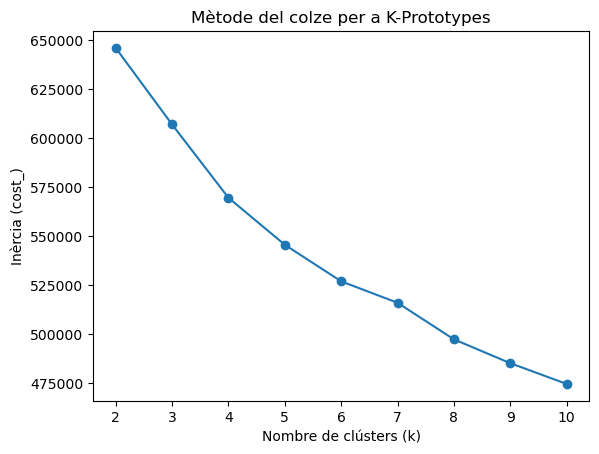

In [ ]:
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# process time: 196min

numeric_features = ['Leucocites_last', 'Leucocites_min', 'Leucocites_max',
       'Leucocites_mean', 'Hemoglobin_last', 'Hemoglobin_min',
       'Hemoglobin_max', 'Hemoglobin_mean', 'Creatinine_last',
       'Creatinine_min', 'Creatinine_max', 'Creatinine_mean', 'K_last',
       'K_min', 'K_max', 'K_mean', 'PCR_last', 'PCR_min', 'PCR_max',
       'PCR_mean', 'FC_last', 'FC_min', 'FC_max', 'FC_mean', 'PULSIOX_last',
       'PULSIOX_min', 'PULSIOX_max', 'PULSIOX_mean', 'FR_last', 'FR_min',
       'FR_max', 'FR_mean', 'TEMP_last', 'TEMP_min', 'TEMP_max', 'TEMP_mean',
       'P_ART_S_last', 'P_ART_S_min', 'P_ART_S_max', 'P_ART_S_mean',
       'age_last', 'age_min', 'age_max', 'age_mean']

discrete_features = ['CAR_RITM_last', 'CAR_RITM_mode', 'EPOC_last',
       'EPOC_mode', 'ESTADO_CONCIENC_last', 'ESTADO_CONCIENC_mode',
       'O2_DIS_last', 'O2_DIS_mode']


# 1. Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(df_km[numeric_features])

# 2. Prepare categorical features as strings
X_cat = df_km[discrete_features].astype(str).values

# 3. Combine numeric and categorical arrays
X_mixed = np.hstack((X_num, X_cat))

# 4. Identify indices of categorical columns in the combined array
categ_idx = list(range(X_num.shape[1], X_mixed.shape[1]))

# 5. Elbow method: compute inertia (cost_) for k = 2 to 10
ks = list(range(2, 11))
inertias = []

for k in ks:
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    kproto.fit_predict(X_mixed, categorical=categ_idx)
    inertias.append(kproto.cost_)

# 7. Plot inertia vs k
plt.figure()
plt.plot(ks, inertias, marker='o')
plt.xlabel('Nombre de clústers (k)')
plt.ylabel('Inèrcia (cost_)')
plt.title('Mètode del colze per a K-Prototypes')
plt.xticks(ks)
plt.show()


In [51]:
# We will use k=4 as the number of clusters. 

# Fit K-Prototypes with k=4
k=4
kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
kproto.fit_predict(X_mixed, categorical=categ_idx)




array([1, 2, 0, ..., 2, 0, 0], dtype=uint16)

In [84]:

# Transform centroids to DataFrame for better readability 
centroids = pd.DataFrame(kproto.cluster_centroids_, columns=[numeric_features + discrete_features])

# Inverse transform numeric features to original scale
# Note: This assumes the scaler was fitted on the same data used for clustering
centroids[numeric_features] = scaler.inverse_transform(centroids[numeric_features])
centroids[discrete_features] = centroids[discrete_features].apply(lambda x: x.astype(str).str.replace('b\'', '').str.replace('\'', ''))
centroids

,Leucocites_last,Leucocites_min,Leucocites_max,Leucocites_mean,Hemoglobin_last,Hemoglobin_min,Hemoglobin_max,Hemoglobin_mean,Creatinine_last,Creatinine_min,...,age_max,age_mean,CAR_RITM_last,CAR_RITM_mode,EPOC_last,EPOC_mode,ESTADO_CONCIENC_last,ESTADO_CONCIENC_mode,O2_DIS_last,O2_DIS_mode
0,7.698614,7.001748,8.878970,7.879178,118.342780,114.943019,122.414187,118.718218,1.001437,0.954581,...,73.870033,73.870033,CAR_RITM_1,CAR_RITM_1,EPOC_1,EPOC_1,ESTADO_CONCIENC_1,ESTADO_CONCIENC_1,O2_DIS_6,O2_DIS_6
1,7.388059,6.706597,8.536732,7.530160,116.688553,113.457193,120.333831,116.927646,0.845026,0.809358,...,42.764347,42.764347,CAR_RITM_1,CAR_RITM_1,EPOC_1,EPOC_1,ESTADO_CONCIENC_1,ESTADO_CONCIENC_1,O2_DIS_6,O2_DIS_6
2,7.724896,6.145468,10.526556,8.012326,99.228483,92.039641,106.733490,99.373097,4.474521,3.697153,...,66.304721,66.304721,CAR_RITM_1,CAR_RITM_1,EPOC_1,EPOC_1,ESTADO_CONCIENC_1,ESTADO_CONCIENC_1,O2_DIS_6,O2_DIS_6
3,8.682040,6.958749,12.117926,9.113797,98.181893,90.449663,105.965729,98.414461,0.955898,0.839289,...,69.897030,69.897030,CAR_RITM_1,CAR_RITM_1,EPOC_1,EPOC_1,ESTADO_CONCIENC_1,ESTADO_CONCIENC_1,O2_DIS_6,O2_DIS_6


In [93]:
# Analyze relationship between clusters and clinical outcomes
import pandas as pd
from scipy.stats import chi2_contingency

# Create DataFrame with cluster assignments and outcomes
df_results = pd.DataFrame({
    'cluster': kproto.labels_.transpose(),
    'event': df_km.y
})

# Create contingency table (cluster vs outcome)
ct = pd.crosstab(df_results.cluster, df_results.event)
print("Contingency Table (rows: clusters, columns: outcomes)")
print(ct)

# Chi-square test to evaluate association between clusters and outcomes
chi2, p, _, _ = chi2_contingency(ct)
print(f"\nChi-square test: chi2={chi2:.2f}, p={p:.3f}")
print("Interpretation: p<0.05 indicates significant association between clusters and outcomes")

Contingency Table (rows: clusters, columns: outcomes)
event       0    1
cluster           
0        6314  380
1        4274  152
2         598  101
3        3378  730

Chi-square test: chi2=696.00, p=0.000
Interpretation: p<0.05 indicates significant association between clusters and outcomes


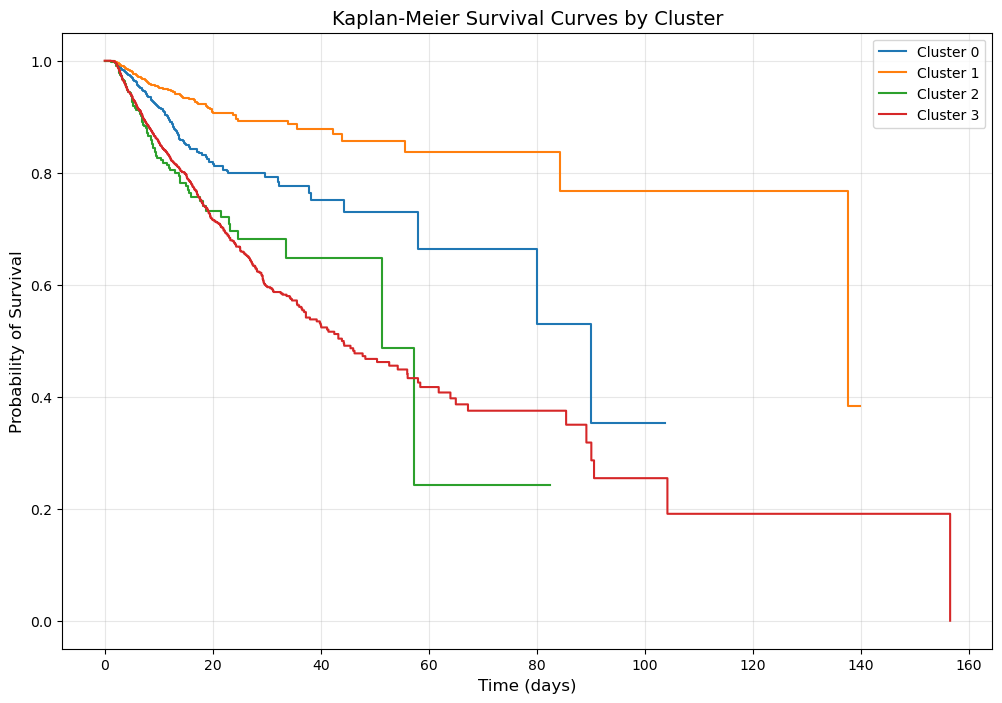

In [100]:

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
# Create summary dataframe with stay duration and outcome
stays_summary = df_full_sorted.groupby('stay_id').agg(
    first_observation=('time_stamp', 'min'),
    last_observation=('time_stamp', 'max'),
    outcome=('y', 'first')
).reset_index()

# Calculate duration in days for each stay
stays_summary['duration_days'] = (
    stays_summary['last_observation'] - stays_summary['first_observation']
).dt.total_seconds() / (24 * 3600)

# Create arrays for survival analysis in the same order as clusters
stays_order = df_full['stay_id'].unique()
times = np.array([
    stays_summary[stays_summary['stay_id']==stay]['duration_days'].values[0] 
    for stay in stays_order
])
y_event = np.array([
    stays_summary[stays_summary['stay_id']==stay]['outcome'].values[0] 
    for stay in stays_order
])

# Plot Kaplan-Meier survival curves for each cluster
kmf = KaplanMeierFitter()
plt.figure(figsize=(12, 8))

clusters = kproto.labels_.transpose()

for cl in sorted(set(clusters)):
    # Select data for this cluster
    mask = clusters == cl
    # Fit KM model
    kmf.fit(durations=times[mask], 
            event_observed=y_event[mask], 
            label=f"Cluster {cl}")
    # Plot survival function
    kmf.plot_survival_function(ci_show=False)

plt.title("Kaplan-Meier Survival Curves by Cluster", fontsize=14)
plt.xlabel("Time (days)", fontsize=12)
plt.ylabel("Probability of Survival", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.show()

Feature means by cluster:
cluster                   0           1           2           3
Leucocites_last    7.698614    7.388059    7.724896    8.682040
Leucocites_min     7.001748    6.706597    6.145468    6.958749
Leucocites_max     8.878970    8.536732   10.526556   12.117926
Leucocites_mean    7.879178    7.530160    8.012326    9.113797
Hemoglobin_last  118.342780  116.688553   99.228483   98.181893
Hemoglobin_min   114.943019  113.457193   92.039641   90.449663
Hemoglobin_max   122.414187  120.333831  106.733490  105.965729
Hemoglobin_mean  118.718218  116.927646   99.373097   98.414461
Creatinine_last    1.001437    0.845026    4.474521    0.955898
Creatinine_min     0.954581    0.809358    3.697153    0.839289
Creatinine_max     1.120892    0.904688    5.809585    1.206782
Creatinine_mean    1.030867    0.852642    4.735703    0.990330
K_last             4.109673    4.066374    4.436766    4.069711
K_min              3.892240    3.895520    3.976967    3.643226
K_max         

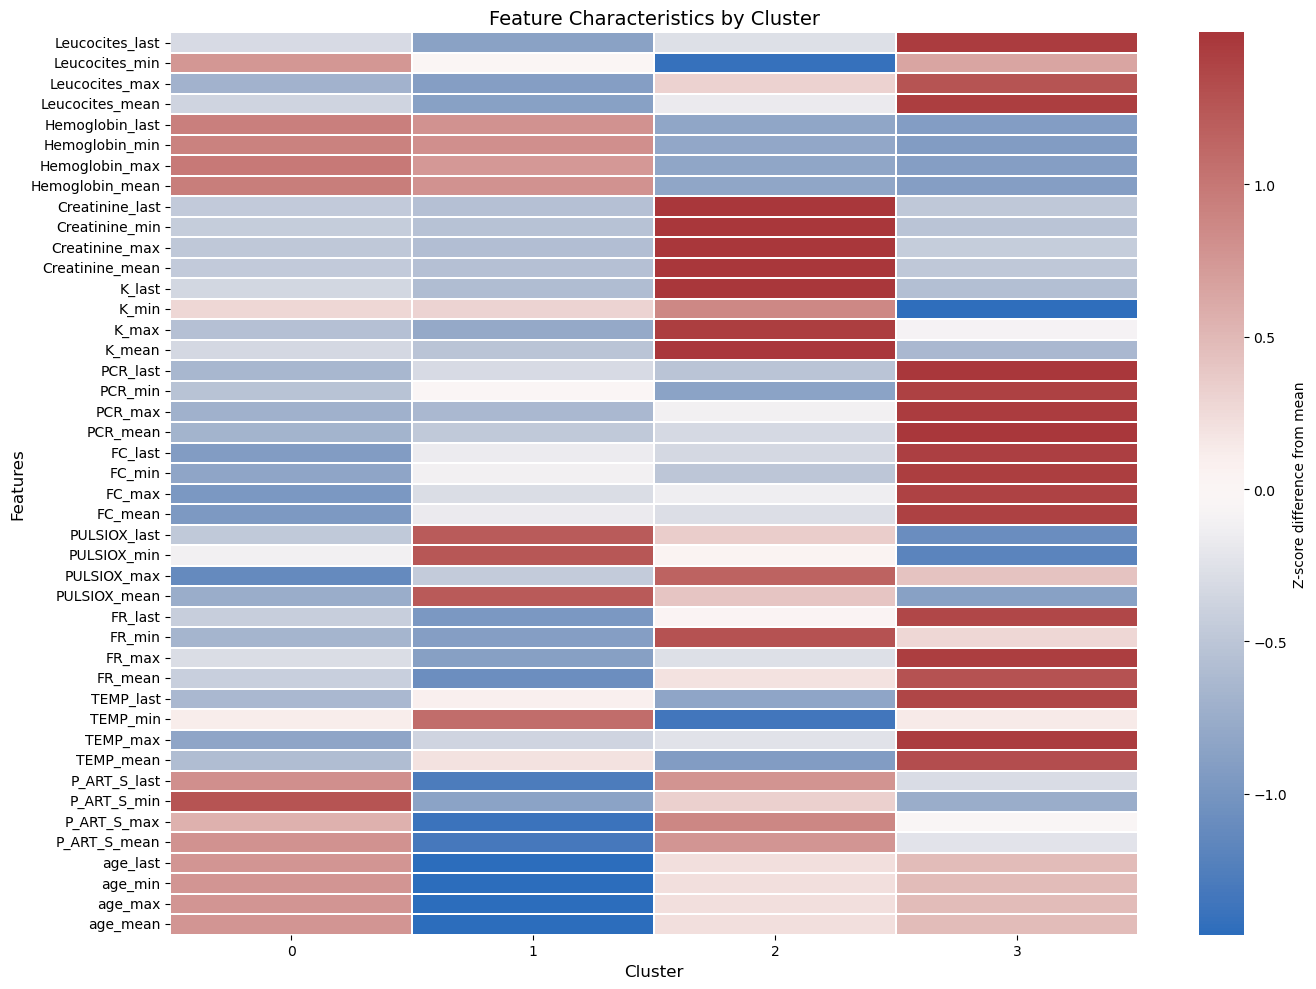

In [106]:
# Analyze and visualize cluster characteristics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame with feature data and cluster assignments

df_features = df_km.drop(columns=['stay_id','y'])
df_features = df_features[numeric_features]
df_features['cluster'] = clusters

# Calculate mean values for each feature by cluster
cluster_means = df_features.groupby('cluster').mean().T
print("Feature means by cluster:")
print(cluster_means)
# Create heatmap of z-score differences to highlight distinctive features

plt.figure(figsize=(14, 10))
# Calculate z-scores for better visualization
z_scores = (cluster_means - cluster_means.mean(axis=1).values[:,None]) / cluster_means.std(axis=1).values[:,None]
sns.heatmap(z_scores, cmap='vlag', center=0, 
            cbar_kws={'label': 'Z-score difference from mean'}, linewidths=0.01)
plt.title('Feature Characteristics by Cluster', fontsize=14)
plt.xticks(fontsize=10)
plt.ylabel('Features', fontsize=12)
plt.xlabel('Cluster', fontsize=12)
plt.tight_layout()
plt.show()

In [34]:
cluster_means.to_csv('cluster_means.csv')